# Imports

In [23]:
import numpy as np
import pandas as pd
import swifter
# import pandas_profiling
import pprint
import pickle
import re

from datetime import datetime
import time

import pytz
#from timezonefinder import TimezoneFinder

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
#from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import lasso_path

from itertools import cycle

## Jupyter Configurations

In [2]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

pd.set_option('display.max_columns', None)

%matplotlib inline

## Function Definitions

In [3]:
def is_dst(dt=None, timezone="UTC"):
    if dt is None:
        dt = datetime.utcnow()
    timezone = pytz.timezone(timezone)
    timezone_aware_date = timezone.localize(dt, is_dst=None)
    return timezone_aware_date.tzinfo._dst.seconds != 0

def multipleReplace(text, wordDict):
    for key in wordDict:
        text = text.replace(key, wordDict[key])
    return text

## Read Data

In [4]:
%%time

df = pd.read_csv("US_Accidents_Dec19.csv")

print('Imported {:,} rows.'.format(len(df)))

Imported 2,974,335 rows.
CPU times: user 33.2 s, sys: 2.09 s, total: 35.3 s
Wall time: 34.9 s


## Prepare the Datetime values

In [5]:
%%time

df['Start_Time'] = pd.to_datetime(df['Start_Time'])
df['End_Time'] = pd.to_datetime(df['End_Time'])
df['Weather_Timestamp'] = pd.to_datetime(df['Weather_Timestamp'])

df["Duration(s)"] = (df["End_Time"] - df["Start_Time"]) // pd.Timedelta('1s')
df['Start_Hour'] = df["Start_Time"].dt.hour
df['Start_Month'] = df["Start_Time"].dt.month
df['Weekend'] = df["Start_Time"].dt.strftime("%A")

# Map Day name of week to number
d = {'Sunday': 1, 'Monday': 0, 'Tuesday': 0, 'Wednesday': 0, 'Thursday': 0, 'Friday': 0, 'Saturday': 1}

df['Weekend'] = df['Weekend'].map(d)



CPU times: user 31.9 s, sys: 966 ms, total: 32.9 s
Wall time: 29.6 s


## Prepare Categorical Variables

In [6]:
%%time

df['Side'] = df['Side'].astype(str)
df.at[df[~df['Side'].isin(['L','R'])].index, 'Side'] = 'U'  #Replace unknown values with U

# df['Airport_Code'] = df['Airport_Code'].astype('category')
# df['Wind_Direction'] = df['Wind_Direction'].astype('category')
# df['Weather_Condition'] = df['Weather_Condition'].astype('category')


# Standarize the Wind_Direction values
wordDict = {'South': 'S', 'West': 'W', 'North': 'N', 'East': 'E', 'Variable': 'VAR', 'Calm': 'CALM'}
df['Wind_Direction'].fillna('VAR', inplace=True)
df['Wind_Direction'] = df.swifter.apply(lambda row: multipleReplace(row['Wind_Direction'], wordDict), axis = 1)


df['Weather_Condition'] = df['Weather_Condition'].replace(' \/ Windy', '', regex=True)

df['Weather_Condition'] = df['Weather_Condition'].replace('T-Storm', 'Thunderstorm', regex=True)
df['Weather_Condition'] = df['Weather_Condition'].replace('Rain with Thunder', 'Thunderstorm', regex=True)
df['Weather_Condition'] = df['Weather_Condition'].replace('Thunderstorms', 'Thunderstorm', regex=True)
df['Weather_Condition'] = df['Weather_Condition'].replace('^Thunder$', 'Thunderstorm', regex=True)

df['Weather_Condition'] = df['Weather_Condition'].replace('Mostly', '', regex=True)
df['Weather_Condition'] = df['Weather_Condition'].replace('Partly', '', regex=True)
df['Weather_Condition'] = df['Weather_Condition'].replace('Scattered', '', regex=True)
df['Weather_Condition'] = df['Weather_Condition'].replace('Light', '', regex=True)
df['Weather_Condition'] = df['Weather_Condition'].replace('Heavy', '', regex=True)
df['Weather_Condition'] = df['Weather_Condition'].replace('Patches of ', '', regex=True)
df['Weather_Condition'] = df['Weather_Condition'].replace(' and Rain', '', regex=True)
df['Weather_Condition'] = df['Weather_Condition'].replace(' in the Vicinity', '', regex=True)
df['Weather_Condition'] = df['Weather_Condition'].replace('Shallow', '', regex=True)
df['Weather_Condition'] = df['Weather_Condition'].replace('Widespread', '', regex=True)
df['Weather_Condition'] = df['Weather_Condition'].replace('Blowing ', '', regex=True)
df['Weather_Condition'] = df['Weather_Condition'].replace('Partial ', '', regex=True)
df['Weather_Condition'] = df['Weather_Condition'].replace('Freezing ', '', regex=True)
df['Weather_Condition'] = df['Weather_Condition'].replace('^Showers$', 'Rain', regex=True)
df['Weather_Condition'] = df['Weather_Condition'].replace(' Showers$', '', regex=True)
df['Weather_Condition'] = df['Weather_Condition'].replace(' Shower$', '', regex=True)
df['Weather_Condition'] = df['Weather_Condition'].replace('Drizzle', 'Rain', regex=True)
df['Weather_Condition'] = df['Weather_Condition'].replace(' Grains', '', regex=True)
df['Weather_Condition'] = df['Weather_Condition'].replace('Thunder and Hail', 'Hail', regex=True)
df['Weather_Condition'] = df['Weather_Condition'].replace('Thunderstorm with Small Hail', 'Hail', regex=True)
df['Weather_Condition'] = df['Weather_Condition'].replace('N/A Precipitation', 'None', regex=True)
df['Weather_Condition'] = df['Weather_Condition'].replace('with Thunder', '', regex=True)
df['Weather_Condition'] = df['Weather_Condition'].replace('Thunderstorm and', '', regex=True)
df['Weather_Condition'] = df['Weather_Condition'].replace('Small Hail', 'Hail', regex=True)
df['Weather_Condition'] = df['Weather_Condition'].replace('Low Drifting Snow', 'Snow', regex=True)
df['Weather_Condition'] = df['Weather_Condition'].replace('(\w+)\s\w+\s\w+$', r'\1', regex=True)

df['Weather_Condition'] = df['Weather_Condition'].replace(' Whirls', '', regex=True)

df['Weather_Condition'] = df['Weather_Condition'].replace('Cloudy', 'Overcast', regex=True)
df['Weather_Condition'] = df['Weather_Condition'].replace('Clouds', 'Overcast', regex=True)

df['Weather_Condition'] = df['Weather_Condition'].replace('Fair', 'Clear', regex=True)
df['Weather_Condition'] = df['Weather_Condition'].replace('None', 'Clear', regex=True)

df['Weather_Condition'] = df['Weather_Condition'].replace('Volcanic Ash', 'Dust', regex=True)
df['Weather_Condition'] = df['Weather_Condition'].replace('Sand', 'Dust', regex=True)

df['Weather_Condition'] = df['Weather_Condition'].replace('Ice Pellets', 'Hail', regex=True)

df['Weather_Condition'] = df['Weather_Condition'].replace('Wintry Mix', 'Sleet', regex=True)

df['Weather_Condition'] = df['Weather_Condition'].replace('Squalls', 'Thunderstorm', regex=True)

df['Weather_Condition'] = df['Weather_Condition'].replace('Snow ', 'Snow', regex=True)

df['Weather_Condition'] = df['Weather_Condition'].replace('Haze', 'Fog', regex=True)
df['Weather_Condition'] = df['Weather_Condition'].replace('Smoke', 'Fog', regex=True)

df['Weather_Condition'] = df['Weather_Condition'].replace('Mist', 'Rain', regex=True)

df['Weather_Condition'] = df['Weather_Condition'].replace('^(\w+)\s\/.+$', r'\1', regex=True)

df['Weather_Condition'] = df['Weather_Condition'].replace('^\s+', '', regex=True) #Remove leading spaces

CPU times: user 1min 56s, sys: 3.36 s, total: 2min
Wall time: 2min


In [7]:
print(df['Weather_Condition'].unique())

['Rain' 'Overcast' 'Snow' 'Fog' 'Clear' nan 'Thunderstorm' 'Dust' 'Hail'
 'Thunder' 'Funnel Cloud' 'Sleet' 'Tornado']


In [8]:
# Fill in precipitation with 1/0

# Weather conditions with precipitation
precip_conds = ['Rain', 'Snow', 'Thunderstorm', 'Hail', 'Sleet']

# Fill with a 1 if precipitation present
df['Precipitation'] = np.where(((df['Precipitation(in)'].isnull()) & (df['Weather_Condition'].isin(precip_conds))),\
                                   1, df['Precipitation(in)'].apply(np.ceil))

# Fill with a 0 otherwise
df['Precipitation'].fillna(0, inplace=True)

# Set all non-zero to 1
df['Precipitation'] = np.where(df['Precipitation'].ne(0), 1, 0)

In [9]:
print(df['Precipitation'].unique())

print(df['Precipitation'].value_counts())

[1 0]
0    2738161
1     236174
Name: Precipitation, dtype: int64


In [10]:
print(df['Precipitation(in)'].isna().sum())

1998358


## One Hot Encoding

In [11]:
def encode_and_bind(original_dataframe, feature_to_encode):
    dummies = pd.get_dummies(original_dataframe[[feature_to_encode]])
    res = pd.concat([original_dataframe, dummies], axis=1)
    res = res.drop([feature_to_encode], axis=1)
    return(res) 

features_to_encode = ['Wind_Direction', 'Weather_Condition',
                     'Amenity', 'Bump', 'Crossing', 'Give_Way', 'Junction', 'No_Exit', 
                     'Railway', 'Roundabout', 'Station', 'Stop', 'Traffic_Calming', 
                     'Traffic_Signal', 'Turning_Loop', 'Sunrise_Sunset', 'Civil_Twilight',
                     'Nautical_Twilight', 'Astronomical_Twilight']

df_ohe = encode_and_bind(df, 'Timezone')

for feature in features_to_encode:
    df_ohe = encode_and_bind(df_ohe, feature)
    



# Data Cleaning

## Fill missing numeric values

In [13]:
%%time

df_ohe['Temperature(F)'].fillna(df_ohe['Temperature(F)'].mean(), inplace=True)
df_ohe['Wind_Chill(F)'].fillna(df_ohe['Temperature(F)'], inplace=True)   #Went with Temp due to Wind_Chill.mean() giving values that didn't make sense.
df_ohe['Wind_Speed(mph)'].fillna(df_ohe['Wind_Speed(mph)'].mean(), inplace=True)
#df_ohe['Precipitation(in)'].fillna(df_ohe['Precipitation(in)'].mean(), inplace=True)
df_ohe['Humidity(%)'].fillna(df_ohe['Humidity(%)'].mean(), inplace=True)
df_ohe['Pressure(in)'].fillna(df_ohe['Pressure(in)'].mean(), inplace=True)
df_ohe['Visibility(mi)'].fillna(df_ohe['Visibility(mi)'].mean(), inplace=True)



CPU times: user 373 ms, sys: 22.6 ms, total: 396 ms
Wall time: 146 ms


## Split into train/test

In [14]:
print(df_ohe.head())

print(list(df_ohe.columns))

train, test = train_test_split(df_ohe, test_size = 0.3, random_state = 126)


    ID    Source    TMC  Severity          Start_Time            End_Time  \
0  A-1  MapQuest  201.0         3 2016-02-08 05:46:00 2016-02-08 11:00:00   
1  A-2  MapQuest  201.0         2 2016-02-08 06:07:59 2016-02-08 06:37:59   
2  A-3  MapQuest  201.0         2 2016-02-08 06:49:27 2016-02-08 07:19:27   
3  A-4  MapQuest  201.0         3 2016-02-08 07:23:34 2016-02-08 07:53:34   
4  A-5  MapQuest  201.0         2 2016-02-08 07:39:07 2016-02-08 08:09:07   

   Start_Lat  Start_Lng  End_Lat  End_Lng  Distance(mi)  \
0  39.865147 -84.058723      NaN      NaN          0.01   
1  39.928059 -82.831184      NaN      NaN          0.01   
2  39.063148 -84.032608      NaN      NaN          0.01   
3  39.747753 -84.205582      NaN      NaN          0.01   
4  39.627781 -84.188354      NaN      NaN          0.01   

                                         Description  Number  \
0  Right lane blocked due to accident on I-70 Eas...     NaN   
1  Accident on Brice Rd at Tussing Rd. Expect del...  

In [15]:
print(df_ohe.isnull().sum().sort_values(ascending = False))

End_Lat                           2246264
End_Lng                           2246264
Precipitation(in)                 1998358
Number                            1917605
TMC                                728071
Weather_Timestamp                   36705
Airport_Code                         5691
Zipcode                               880
City                                   83
Description                             1
Start_Hour                              0
Start_Month                             0
Weekend                                 0
Temperature(F)                          0
Precipitation                           0
Timezone_US/Central                     0
Wind_Speed(mph)                         0
Visibility(mi)                          0
Pressure(in)                            0
Humidity(%)                             0
Wind_Chill(F)                           0
Timezone_US/Eastern                     0
Duration(s)                             0
Astronomical_Twilight_Night       

## Scatterplots

/Users/nathancrugge/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


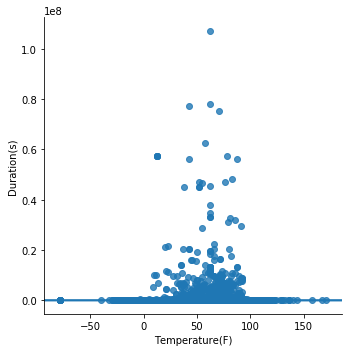

In [10]:
sns.lmplot('Temperature(F)', 'Duration(s)', train)


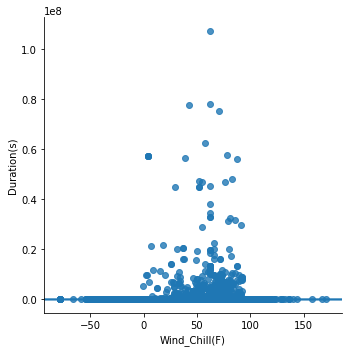

In [11]:
sns.lmplot('Wind_Chill(F)', 'Duration(s)', train)

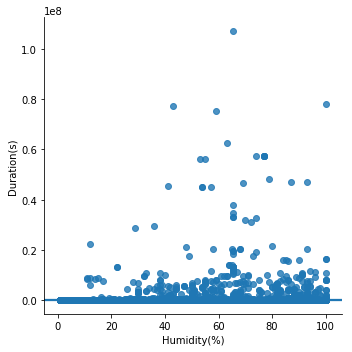

In [12]:
sns.lmplot('Humidity(%)', 'Duration(s)', train)

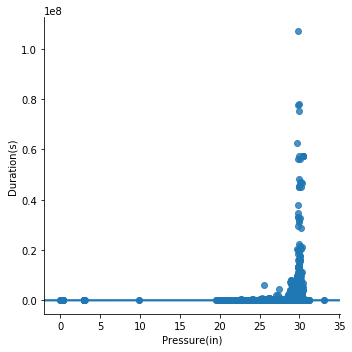

In [13]:
sns.lmplot('Pressure(in)', 'Duration(s)', train)

# Feature Selection
## Random Forest & Gradient Boosting Regressors

In [50]:
# Excluded potential predictors:
# Pressure(in) - There is a mass point at ~30, which is also where all the severity is (was massively skewing the lasso results); probably some default value?
# Precipitation(in) - Used a y/n based on this field plus Weather_Condition instead
# Removed all of the _Night dummy variables, since I'm including the _Day versions
predictor_cols = ['Temperature(F)', 'Wind_Chill(F)', 'Humidity(%)', 'Visibility(mi)', 'Wind_Speed(mph)',  
                  'Start_Hour', 'Start_Month', 'Weekend', 'Precipitation', 'Timezone_US/Central', 'Timezone_US/Eastern', 'Timezone_US/Mountain', 
                  'Timezone_US/Pacific', 'Wind_Direction_CALM', 'Wind_Direction_E', 'Wind_Direction_ENE', 'Wind_Direction_ESE', 
                  'Wind_Direction_N', 'Wind_Direction_NE', 'Wind_Direction_NNE', 'Wind_Direction_NNW', 'Wind_Direction_NW', 'Wind_Direction_S', 
                  'Wind_Direction_SE', 'Wind_Direction_SSE', 'Wind_Direction_SSW', 'Wind_Direction_SW', 'Wind_Direction_VAR', 'Wind_Direction_W',
                  'Wind_Direction_WNW', 'Wind_Direction_WSW', 'Weather_Condition_Clear', 'Weather_Condition_Dust', 'Weather_Condition_Fog', 
                  'Weather_Condition_Funnel Cloud', 'Weather_Condition_Hail', 'Weather_Condition_Overcast', 'Weather_Condition_Rain', 
                  'Weather_Condition_Sleet', 'Weather_Condition_Snow', 'Weather_Condition_Thunderstorm', 'Weather_Condition_Tornado', 
                  'Sunrise_Sunset_Day', 'Civil_Twilight_Day', 'Nautical_Twilight_Day', 'Astronomical_Twilight_Day']

x_train = pd.DataFrame(train, columns = predictor_cols)
x_test = pd.DataFrame(test, columns = predictor_cols)

y_train = train['Duration(s)']
y_test = test['Duration(s)']

y_train2 = train['Severity']
y_test2 = test['Severity']

print(x_train.shape)
print(y_train.shape)

(2082034, 46)
(2082034,)


### Random Forest Regressor

In [21]:
# Train on actual duration
rfreg = RandomForestRegressor(random_state = 126, oob_score = True)
rfreg.fit(x_train, y_train)

feature_importances = pd.DataFrame(rfreg.feature_importances_,
                                   index = x_train.columns,
                                    columns=['importance']).sort_values('importance',  ascending=False)
print(feature_importances.head(15))
print("Training OOB Accuracy: ")
print(rfreg.oob_score_)

/Users/nathancrugge/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/nathancrugge/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:732: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
           oob_score=True, random_state=126, verbose=0, warm_start=False)

                            importance
Temperature(F)                0.138426
Pressure(in)                  0.137268
Start_Hour                    0.135288
Humidity(%)                   0.118437
Wind_Speed(mph)               0.076725
Wind_Chill(F)                 0.075346
Wind_Direction_WSW            0.051423
Visibility(mi)                0.045431
Start_Month                   0.034269
Weather_Condition_Clear       0.034134
Weekend                       0.027063
Civil_Twilight_Day            0.026698
Weather_Condition_Overcast    0.018150
Timezone_US/Eastern           0.017114
Sunrise_Sunset_Day            0.015136
Training OOB Accuracy: 
-0.16283669621517127


In [34]:
# Train on 1 to 4 severity rating
rfreg2 = RandomForestRegressor(random_state = 126, oob_score = True)
rfreg2.fit(x_train, y_train2)

feature_importances2 = pd.DataFrame(rfreg2.feature_importances_,
                                   index = x_train.columns,
                                    columns=['importance']).sort_values('importance',  ascending=False)
print(feature_importances2.head(15))
print("Training OOB Accuracy: ")
print(rfreg2.oob_score_)

/Users/nathancrugge/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/nathancrugge/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:732: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
           oob_score=True, random_state=126, verbose=0, warm_start=False)

                            importance
Pressure(in)                  0.173470
Humidity(%)                   0.143450
Wind_Chill(F)                 0.094388
Wind_Speed(mph)               0.092037
Temperature(F)                0.086601
Start_Hour                    0.080376
Start_Month                   0.052965
Visibility(mi)                0.032771
Weekend                       0.018329
Wind_Direction_S              0.011303
Timezone_US/Pacific           0.010757
Wind_Direction_W              0.010678
Weather_Condition_Overcast    0.010388
Wind_Direction_N              0.010035
Weather_Condition_Clear       0.009625
Training OOB Accuracy: 
-0.2988461242007012


### Gradient Boosting Regressor

In [37]:
# Train on actual duration
gbreg = GradientBoostingRegressor(random_state = 126, subsample = 0.5)
gbreg.fit(x_train, y_train)

gb_feature_importances = pd.DataFrame(gbreg.feature_importances_,
                                   index = x_train.columns,
                                    columns=['importance']).sort_values('importance',  ascending=False)
print(gb_feature_importances.head(15))
print("Training OOB Accuracy: ")
print(gbreg.oob_improvement_)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=100, n_iter_no_change=None, presort='auto',
             random_state=126, subsample=0.5, tol=0.0001,
             validation_fraction=0.1, verbose=0, warm_start=False)

                             importance
Weekend                        0.517448
Astronomical_Twilight_Night    0.148930
Wind_Direction_WSW             0.102358
Wind_Direction_VAR             0.071715
Wind_Chill(F)                  0.064373
Humidity(%)                    0.021119
Wind_Speed(mph)                0.013905
Civil_Twilight_Night           0.010784
Temperature(F)                 0.009246
Sunrise_Sunset_Night           0.007961
Start_Hour                     0.007621
Pressure(in)                   0.007347
Astronomical_Twilight_Day      0.005336
Wind_Direction_N               0.003585
Visibility(mi)                 0.002483
Training OOB Accuracy: 
[ 6.92937798e+07  1.32393547e+06  6.32728192e+06 -1.63774170e+07
  4.86764836e+05 -1.43575408e+06 -1.56346361e+06  3.88233380e+07
  1.34610818e+06  8.15550514e+05 -1.63547127e+07  3.12124660e+06
  3.44265202e+08  1.19068544e+08  2.08285269e+08 -1.94778617e+07
 -9.86423215e+04  1.94868213e+07  6.57120736e+06  1.25942526e+08
 -1.9336448

In [38]:
# Train on 1 to 4 severity rating
gbreg2 = GradientBoostingRegressor(random_state = 126, subsample = 0.5)
gbreg2.fit(x_train, y_train2)

gb_feature_importances2 = pd.DataFrame(gbreg2.feature_importances_,
                                   index = x_train.columns,
                                    columns=['importance']).sort_values('importance',  ascending=False)
print(gb_feature_importances2.head(15))
print("Training OOB Improvement: ")
print(gbreg2.oob_improvement_)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=100, n_iter_no_change=None, presort='auto',
             random_state=126, subsample=0.5, tol=0.0001,
             validation_fraction=0.1, verbose=0, warm_start=False)

                           importance
Weekend                      0.287246
Start_Hour                   0.176716
Timezone_US/Pacific          0.114529
Timezone_US/Eastern          0.092610
Pressure(in)                 0.074907
Start_Month                  0.056206
Wind_Speed(mph)              0.040258
Astronomical_Twilight_Day    0.037193
Nautical_Twilight_Day        0.027322
Wind_Chill(F)                0.020763
Sunrise_Sunset_Day           0.009467
Timezone_US/Central          0.009111
Temperature(F)               0.006822
Weather_Condition_Clear      0.006722
Civil_Twilight_Night         0.006696
Training OOB Improvement: 
[1.89159134e-03 1.53658342e-03 1.31627354e-03 1.08391092e-03
 9.16226237e-04 8.88239945e-04 6.50663571e-04 6.59989927e-04
 4.73320737e-04 4.30628322e-04 4.38268378e-04 4.77339539e-04
 3.54299852e-04 2.59601850e-04 3.35077106e-04 2.01486810e-04
 2.66590565e-04 3.20553295e-04 1.85596327e-04 1.60550862e-04
 1.37878354e-04 1.67905802e-04 1.62782728e-04 1.27804520e-04

### Lasso Regression

Computing regularization path using the lasso...
Computing regularization path using the positive lasso...


<Figure size 432x288 with 0 Axes>

Text(0.5, 0, '-Log(alpha)')

Text(0, 0.5, 'coefficients')

Text(0.5, 1.0, 'Lasso and Positive Lasso Paths')

(-3.895278087342583,
 -1.3641450921122038,
 -2810.1414578724107,
 11553.296530196681)

-----------------------
First Non-Zero Coefficient:
['Astronomical_Twilight_Day']
-----------------------
First 2 Non-Zero Coefficients:
['Humidity(%)', 'Astronomical_Twilight_Day']
-----------------------
Top 10 Non-Zero Coefficients:
['Temperature(F)', 'Humidity(%)', 'Start_Month', 'Weekend', 'Timezone_US/Eastern', 'Wind_Direction_CALM', 'Wind_Direction_VAR', 'Wind_Direction_WSW', 'Weather_Condition_Clear', 'Civil_Twilight_Day']


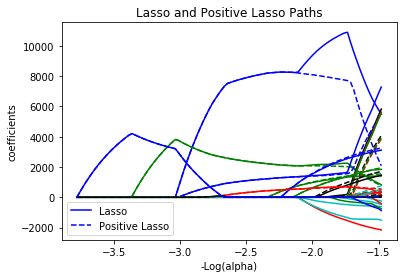

In [53]:
# Train using continuous duration response
# Normalize X values
x_train_std = ((x_train-x_train.min())/(x_train.max()-x_train.min()))

# Compute paths
eps = 5e-3  # the smaller it is the longer is the path

print("Computing regularization path using the lasso...")
alphas_lasso, coefs_lasso, _ = lasso_path(x_train_std, y_train, eps, fit_intercept=False)

print("Computing regularization path using the positive lasso...")
alphas_positive_lasso, coefs_positive_lasso, _ = lasso_path(
    x_train_std, y_train, eps, positive=True, fit_intercept=False)

# Display results
plt.figure()
colors = cycle(['b', 'r', 'g', 'c', 'k'])
neg_log_alphas_lasso = -np.log10(alphas_lasso)
neg_log_alphas_positive_lasso = -np.log10(alphas_positive_lasso)
for coef_l, coef_pl, c in zip(coefs_lasso, coefs_positive_lasso, colors):
    l1 = plt.plot(neg_log_alphas_lasso, coef_l, c=c)
    l2 = plt.plot(neg_log_alphas_positive_lasso, coef_pl, linestyle='--', c=c)

plt.xlabel('-Log(alpha)')
plt.ylabel('coefficients')
plt.title('Lasso and Positive Lasso Paths')
plt.legend((l1[-1], l2[-1]), ('Lasso', 'Positive Lasso'), loc='lower left')
plt.axis('tight')


print('-----------------------')
print('First Non-Zero Coefficient:')
idx = np.array(np.nonzero(coefs_lasso[:,1]))[0]
print([predictor_cols[i] for i in idx])

print('-----------------------')
print('First 2 Non-Zero Coefficients:')
idx = np.array(np.nonzero(coefs_lasso[:,29]))[0]
print([predictor_cols[i] for i in idx])

print('-----------------------')
print('Top 10 Non-Zero Coefficients:')
idx = np.array(np.nonzero(coefs_lasso[:,75]))[0]
print([predictor_cols[i] for i in idx])

Computing regularization path using the lasso...
Computing regularization path using the positive lasso...


<Figure size 432x288 with 0 Axes>

Text(0.5, 0, '-Log(alpha)')

Text(0, 0.5, 'coefficients')

Text(0.5, 1.0, 'Lasso and Positive Lasso Paths')

(-0.4270068134451222,
 2.104126181785257,
 -0.1169949259958322,
 2.456893445912476)

-----------------------
First 10 Non-Zero Coefficients:
['Temperature(F)', 'Humidity(%)', 'Start_Hour', 'Weekend', 'Timezone_US/Eastern', 'Timezone_US/Mountain', 'Timezone_US/Pacific', 'Weather_Condition_Clear', 'Weather_Condition_Overcast', 'Astronomical_Twilight_Day']


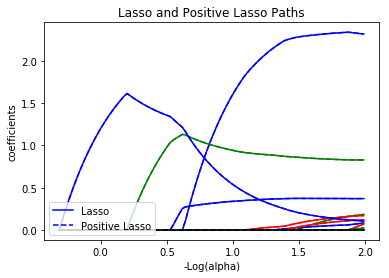

In [55]:
# Train using 1 to 4 severity measure
print("Computing regularization path using the lasso...")
alphas_lasso, coefs_lasso, _ = lasso_path(x_train_std, y_train2, eps, fit_intercept=False)

print("Computing regularization path using the positive lasso...")
alphas_positive_lasso, coefs_positive_lasso, _ = lasso_path(
    x_train_std, y_train2, eps, positive=True, fit_intercept=False)

# Display results
plt.figure()
colors = cycle(['b', 'r', 'g', 'c', 'k'])
neg_log_alphas_lasso = -np.log10(alphas_lasso)
neg_log_alphas_positive_lasso = -np.log10(alphas_positive_lasso)
for coef_l, coef_pl, c in zip(coefs_lasso, coefs_positive_lasso, colors):
    l1 = plt.plot(neg_log_alphas_lasso, coef_l, c=c)
    l2 = plt.plot(neg_log_alphas_positive_lasso, coef_pl, linestyle='--', c=c)

plt.xlabel('-Log(alpha)')
plt.ylabel('coefficients')
plt.title('Lasso and Positive Lasso Paths')
plt.legend((l1[-1], l2[-1]), ('Lasso', 'Positive Lasso'), loc='lower left')
plt.axis('tight')

idx = np.array(np.nonzero(coefs_lasso[:,99]))[0]

print('-----------------------')
print('First 10 Non-Zero Coefficients:')
print([predictor_cols[i] for i in idx])


## Models by State Testing

#### CA Only

In [39]:
x_train_CA = train.loc[train['State'] == 'CA']
x_test_CA = test.loc[test['State'] == 'CA']

x_trainCA = pd.DataFrame(x_train_CA, columns = predictor_cols)
x_testCA = pd.DataFrame(x_test_CA, columns = predictor_cols)

y_trainCA = x_train_CA['Duration(s)']
y_testCA = x_test_CA['Duration(s)']

y_train2CA = x_train_CA['Severity']
y_test2CA = x_test_CA['Severity']

print(x_trainCA.shape)
print(y_trainCA.shape)

(463982, 51)
(463982,)


In [40]:
# Train on actual duration
gbreg = GradientBoostingRegressor(random_state = 126, subsample = 0.5)
gbreg.fit(x_trainCA, y_trainCA)

gb_feature_importances = pd.DataFrame(gbreg.feature_importances_,
                                   index = x_trainCA.columns,
                                    columns=['importance']).sort_values('importance',  ascending=False)
print(gb_feature_importances.head(15))

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=100, n_iter_no_change=None, presort='auto',
             random_state=126, subsample=0.5, tol=0.0001,
             validation_fraction=0.1, verbose=0, warm_start=False)

                             importance
Start_Hour                     0.482051
Visibility(mi)                 0.099293
Pressure(in)                   0.094456
Temperature(F)                 0.084687
Wind_Chill(F)                  0.060703
Wind_Direction_CALM            0.055005
Wind_Speed(mph)                0.038705
Wind_Direction_SW              0.027229
Humidity(%)                    0.023865
Wind_Direction_S               0.020520
Weekend                        0.007738
Start_Month                    0.005027
Astronomical_Twilight_Night    0.000204
Wind_Direction_SSW             0.000185
Weather_Condition_Fog          0.000116


In [41]:
# Train on 1 to 4 severity rating
gbreg2 = GradientBoostingRegressor(random_state = 126, subsample = 0.5)
gbreg2.fit(x_trainCA, y_train2CA)

gb_feature_importances2 = pd.DataFrame(gbreg2.feature_importances_,
                                   index = x_trainCA.columns,
                                    columns=['importance']).sort_values('importance',  ascending=False)
print(gb_feature_importances2.head(15))

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=100, n_iter_no_change=None, presort='auto',
             random_state=126, subsample=0.5, tol=0.0001,
             validation_fraction=0.1, verbose=0, warm_start=False)

                             importance
Start_Month                    0.210273
Pressure(in)                   0.207721
Weekend                        0.160582
Wind_Speed(mph)                0.147365
Start_Hour                     0.050792
Humidity(%)                    0.041547
Wind_Chill(F)                  0.032288
Temperature(F)                 0.025278
Astronomical_Twilight_Night    0.019868
Wind_Direction_CALM            0.016066
Nautical_Twilight_Night        0.012252
Civil_Twilight_Night           0.011430
Wind_Direction_NW              0.007883
Wind_Direction_NNW             0.007543
Visibility(mi)                 0.007490


#### TX Only

In [42]:
x_train_TX = train.loc[train['State'] == 'TX']
x_test_TX = test.loc[test['State'] == 'TX']

x_trainTX = pd.DataFrame(x_train_TX, columns = predictor_cols)
x_testTX = pd.DataFrame(x_test_TX, columns = predictor_cols)

y_trainTX = x_train_TX['Duration(s)']
y_testTX = x_test_TX['Duration(s)']

y_train2TX = x_train_TX['Severity']
y_test2TX = x_test_TX['Severity']

print(x_trainTX.shape)
print(y_trainTX.shape)

(208787, 51)
(208787,)


In [43]:
# Train on actual duration
gbreg = GradientBoostingRegressor(random_state = 126, subsample = 0.5)
gbreg.fit(x_trainTX, y_trainTX)

gb_feature_importances = pd.DataFrame(gbreg.feature_importances_,
                                   index = x_trainTX.columns,
                                    columns=['importance']).sort_values('importance',  ascending=False)
print(gb_feature_importances.head(15))

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=100, n_iter_no_change=None, presort='auto',
             random_state=126, subsample=0.5, tol=0.0001,
             validation_fraction=0.1, verbose=0, warm_start=False)

                                importance
Wind_Speed(mph)                   0.408210
Pressure(in)                      0.167231
Wind_Direction_N                  0.164681
Start_Month                       0.105739
Visibility(mi)                    0.060670
Weather_Condition_Rain            0.052692
Precipitation                     0.020302
Start_Hour                        0.011610
Humidity(%)                       0.002903
Temperature(F)                    0.002695
Wind_Chill(F)                     0.001654
Wind_Direction_VAR                0.001066
Wind_Direction_NE                 0.000218
Wind_Direction_CALM               0.000129
Weather_Condition_Thunderstorm    0.000122


In [44]:
# Train on 1 to 4 severity rating
gbreg2 = GradientBoostingRegressor(random_state = 126, subsample = 0.5)
gbreg2.fit(x_trainTX, y_train2TX)

gb_feature_importances2 = pd.DataFrame(gbreg2.feature_importances_,
                                   index = x_trainTX.columns,
                                    columns=['importance']).sort_values('importance',  ascending=False)
print(gb_feature_importances2.head(15))

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=100, n_iter_no_change=None, presort='auto',
             random_state=126, subsample=0.5, tol=0.0001,
             validation_fraction=0.1, verbose=0, warm_start=False)

                      importance
Start_Hour              0.320123
Weekend                 0.224758
Pressure(in)            0.056474
Wind_Speed(mph)         0.049523
Timezone_US/Mountain    0.047217
Wind_Chill(F)           0.037636
Start_Month             0.035489
Visibility(mi)          0.034448
Wind_Direction_VAR      0.028266
Sunrise_Sunset_Night    0.027935
Humidity(%)             0.025106
Temperature(F)          0.022445
Civil_Twilight_Day      0.014767
Civil_Twilight_Night    0.011302
Timezone_US/Central     0.010533
